In [147]:
import torch
import torchvision.transforms as transforms

Image Transformations

In [ ]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])


Dataset Loading

In [149]:
import medmnist
from medmnist import OCTMNIST
from medmnist import INFO
from torch.utils.data import DataLoader


data_flag = 'octmnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

Statistics

In [168]:
train_labels = np.array(train_dataset.labels).flatten()
val_labels = np.array(val_dataset.labels).flatten()
test_labels = np.array(test_dataset.labels).flatten()

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

print("Train class counts:", np.bincount(train_labels))
print("Val class counts:", np.bincount(val_labels))
print("Test class counts:", np.bincount(test_labels))


Train size: 97477
Val size: 10832
Test size: 1000
Train class counts: [33484 10213  7754 46026]
Val class counts: [3721 1135  862 5114]
Test class counts: [250 250 250 250]


Test, Train, Validation

In [150]:
download = False
train_dataset = OCTMNIST(split='train', transform=transform, download=download)
val_dataset = OCTMNIST(split='val', transform=transform, download=download)
test_dataset = OCTMNIST(split='test', transform=transform, download=download)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 97477
Validation samples: 10832
Test samples: 1000


Visualization

Class Distribution

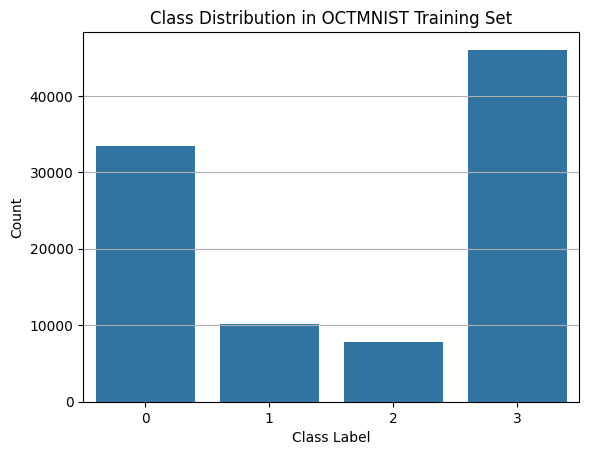

In [169]:
import seaborn as sns
sns.countplot(x=train_labels)
plt.title("Class Distribution in OCTMNIST Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


Sample Images 

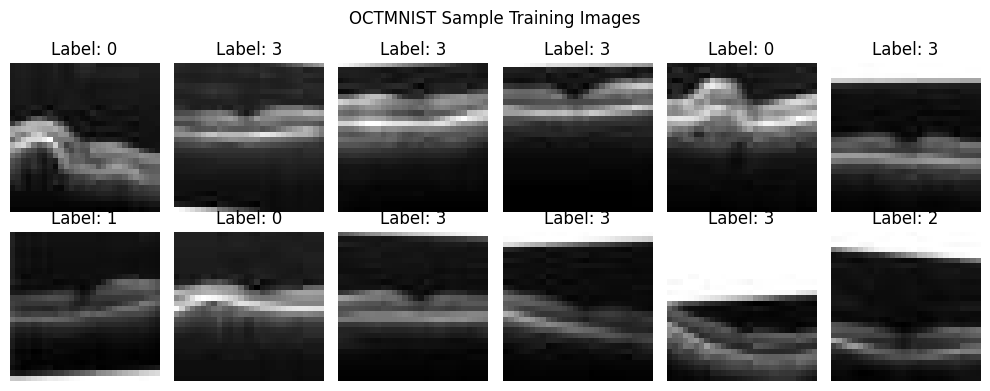

In [151]:
import numpy as np
import matplotlib.pyplot as plt

def sample_images(dataset, title="Sample OCT Images"):
    images, labels = dataset.imgs[:12], dataset.labels[:12]
    plt.figure(figsize=(10, 4))
    for i in range(12):
        plt.subplot(2, 6, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i][0]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

sample_images(train_dataset, "OCTMNIST Sample Training Images")


Pixel Intensity Histogram

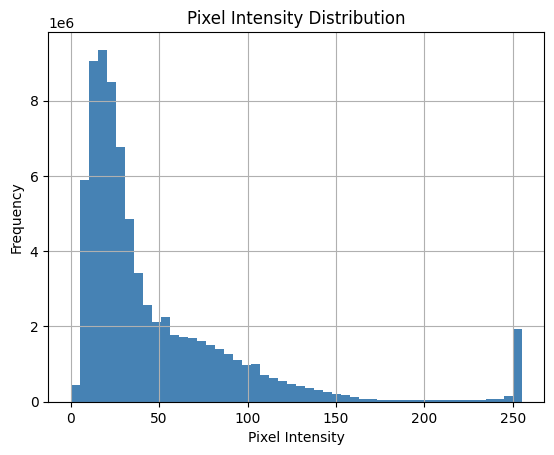

In [166]:
plt.hist(train_dataset.imgs.flatten(), bins=50, color='steelblue')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Base Model

In [152]:
import torch.nn as nn
import torch.nn.functional as F

class OCTCNN(nn.Module):
    def __init__(self):
        super(OCTCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 → 14x14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14 → 7x7

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # [B, 128, 1, 1]
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


In [153]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCTCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
#Stack Overflow

In [154]:
import time
num_epochs = 20
train_accs, val_accs = [], []
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.squeeze().long().to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")


Epoch 1/20 | Train Acc: 0.8185 | Val Acc: 0.7662 | LR: 0.001000
Epoch 2/20 | Train Acc: 0.8587 | Val Acc: 0.8427 | LR: 0.001000
Epoch 3/20 | Train Acc: 0.8718 | Val Acc: 0.8339 | LR: 0.001000
Epoch 4/20 | Train Acc: 0.8793 | Val Acc: 0.8741 | LR: 0.001000
Epoch 5/20 | Train Acc: 0.8842 | Val Acc: 0.8774 | LR: 0.001000
Epoch 6/20 | Train Acc: 0.8883 | Val Acc: 0.8486 | LR: 0.001000
Epoch 7/20 | Train Acc: 0.8912 | Val Acc: 0.8881 | LR: 0.001000
Epoch 8/20 | Train Acc: 0.8949 | Val Acc: 0.8790 | LR: 0.001000
Epoch 9/20 | Train Acc: 0.8963 | Val Acc: 0.8807 | LR: 0.001000
Epoch 10/20 | Train Acc: 0.8973 | Val Acc: 0.8593 | LR: 0.001000
Epoch 11/20 | Train Acc: 0.8998 | Val Acc: 0.9000 | LR: 0.001000
Epoch 12/20 | Train Acc: 0.9018 | Val Acc: 0.8998 | LR: 0.001000
Epoch 13/20 | Train Acc: 0.9027 | Val Acc: 0.8955 | LR: 0.001000
Epoch 14/20 | Train Acc: 0.9040 | Val Acc: 0.9021 | LR: 0.001000
Epoch 15/20 | Train Acc: 0.9044 | Val Acc: 0.8902 | LR: 0.001000
Epoch 16/20 | Train Acc: 0.9055 | 

Evaluation on the test set

In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.squeeze().long().to(device)
        out = model(X_test)
        pred = out.argmax(1)
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

test_acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Final Test Accuracy: {test_acc * 100:.2f}%")


✅ Final Test Accuracy: 75.20%


Confusion Matrix

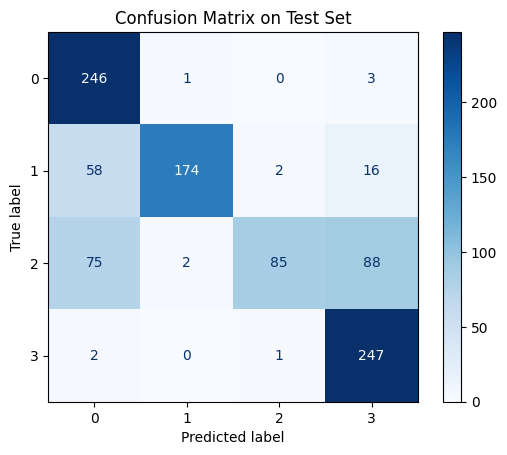

In [158]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

Plots

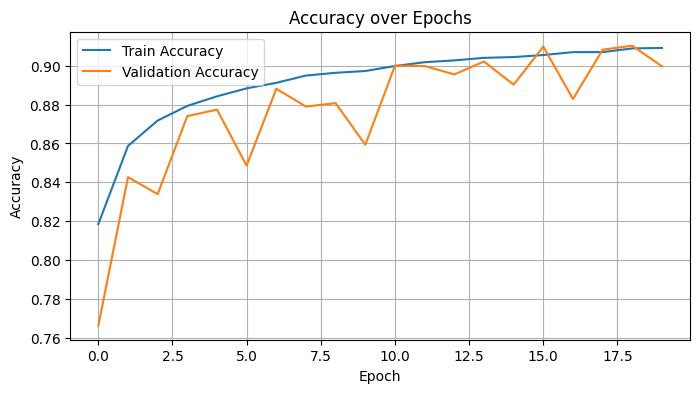

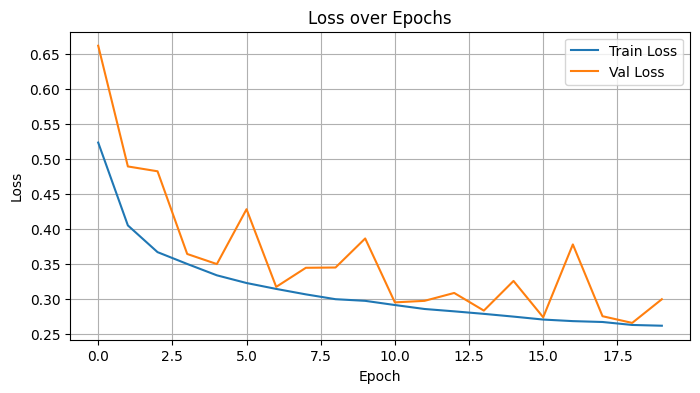

In [157]:
plt.figure(figsize=(8, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Improved NN

In [159]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [160]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),   
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                  

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                  

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                  

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))     
        )
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 4)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


In [161]:
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [162]:
num_epochs = 30
train_accs, val_accs = [], []
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.squeeze().long().to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1/30 | Train Acc: 0.8293 | Val Acc: 0.8584 | LR: 0.010000
Epoch 2/30 | Train Acc: 0.8719 | Val Acc: 0.7145 | LR: 0.010000
Epoch 3/30 | Train Acc: 0.8847 | Val Acc: 0.8839 | LR: 0.010000
Epoch 4/30 | Train Acc: 0.8933 | Val Acc: 0.8842 | LR: 0.010000
Epoch 5/30 | Train Acc: 0.8994 | Val Acc: 0.8893 | LR: 0.010000
Epoch 6/30 | Train Acc: 0.9044 | Val Acc: 0.8629 | LR: 0.010000
Epoch 7/30 | Train Acc: 0.9082 | Val Acc: 0.8900 | LR: 0.010000
Epoch 8/30 | Train Acc: 0.9108 | Val Acc: 0.9146 | LR: 0.010000
Epoch 9/30 | Train Acc: 0.9147 | Val Acc: 0.9030 | LR: 0.010000
Epoch 10/30 | Train Acc: 0.9175 | Val Acc: 0.9129 | LR: 0.010000
Epoch 11/30 | Train Acc: 0.9196 | Val Acc: 0.9105 | LR: 0.010000
Epoch 12/30 | Train Acc: 0.9223 | Val Acc: 0.9158 | LR: 0.010000
Epoch 13/30 | Train Acc: 0.9234 | Val Acc: 0.9141 | LR: 0.010000
Epoch 14/30 | Train Acc: 0.9268 | Val Acc: 0.9067 | LR: 0.010000
Epoch 15/30 | Train Acc: 0.9257 | Val Acc: 0.9165 | LR: 0.010000
Epoch 16/30 | Train Acc: 0.9314 | 

In [163]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Test Accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Final Test Accuracy (ImprovedNN): {test_acc * 100:.2f}%")


✅ Final Test Accuracy (ImprovedNN): 75.90%


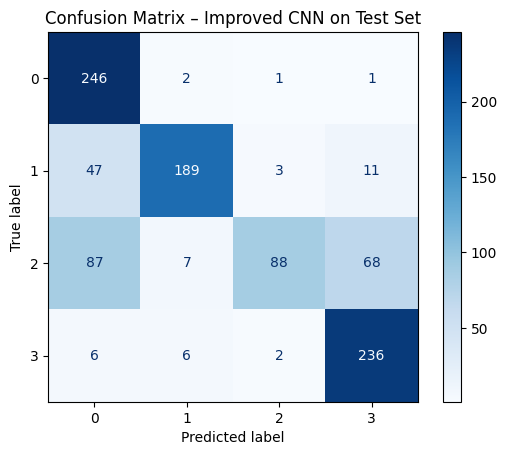

In [164]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Improved CNN on Test Set")
plt.grid(False)
plt.show()


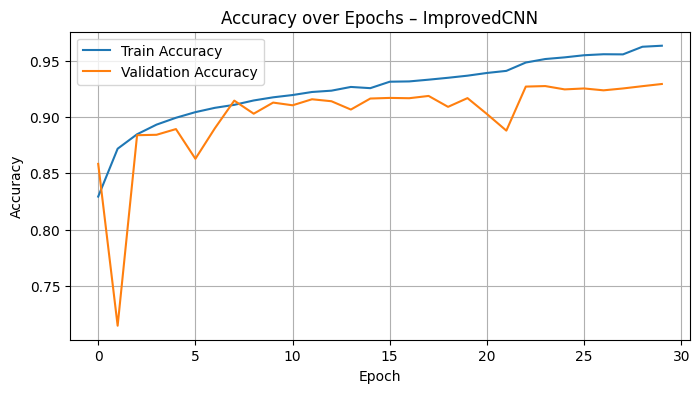

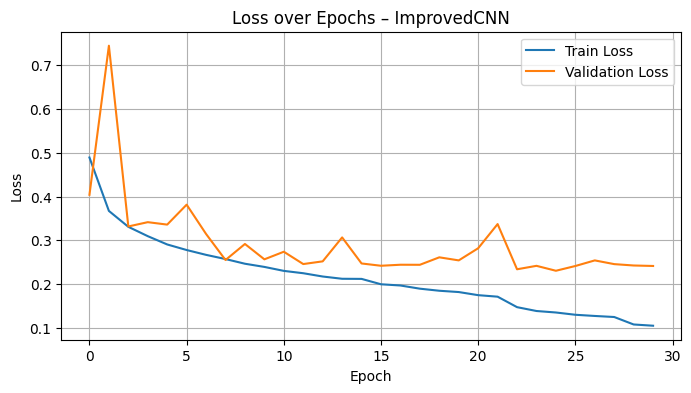

In [165]:
plt.figure(figsize=(8, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title("Accuracy over Epochs – ImprovedCNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs – ImprovedCNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(model.state_dict(), "improved_cnn_weights.pth")